### Import and init GPU

In [1]:
from IPython.display import Audio

In [2]:
import sys
sys.path.append('../../../../')

In [3]:
import numpy as np
import math

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn

import pickle
import argparse
import time
import itertools
from copy import deepcopy
import tensorflow as tf

from tuner import HyperparameterTuner
from tuner import MyTask

use_tpu = False
use_gpu = True

if use_tpu:
    from tensorflow.contrib import tpu
    from tensorflow.contrib.cluster_resolver import TPUClusterResolver

if use_gpu:
    import os
    
%load_ext autoreload
%autoreload 2

In [4]:
if use_gpu:
    os.environ['CUDA_VISIBLE_DEVICES'] = '2'
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True

In [5]:
if use_tpu:
    tpu_cluster = TPUClusterResolver(tpu=[tpu_name]).get_master()
    sess = tf.Session(tpu_cluster)
    sess.run(tpu.initialize_system())
elif use_gpu:
    sess = tf.Session(config=config)
else:
    sess = tf.Session()

In [6]:
from resnet import Network

In [7]:
network = Network()

In [8]:
task_home = ''
if use_tpu:
    pass
#     task_home = 'gs://continual_learning/permMNIST_EWC/'
else:
    task_home = '../../../../../'

cur_dir = './'
checkpoint_path = cur_dir + 'checkpoints_0_no_distill/'
summaries_path = cur_dir + 'summaries_0_no_distill/'
data_path = task_home + 'cifar-100-python/'
split_path = './split.txt' 
if use_tpu:
    tpu_name = 'gectpu'
    
BATCH_SIZE = 128

### Dataset loading functions

In [9]:
label_smooth_param = 0

def splitDataset(dataset, dataset_split, seed):
    np.random.seed(seed)
    task_list = []
    train_labels = np.argmax(dataset.train.labels, axis=1)
    validation_labels = np.argmax(dataset.validation.labels, axis=1)
    test_labels = np.argmax(dataset.test.labels, axis=1)
    for i in range(len(dataset_split)):
        cur_train_indices = [False] * dataset.train.images.shape[0]
        cur_validation_indices = [False] * dataset.validation.images.shape[0]
        cur_test_indices = [False] * dataset.test.images.shape[0]
        for j in range(len(dataset_split[i])):
            cur_train_indices = np.logical_or(cur_train_indices, (train_labels == dataset_split[i][j]))
            cur_validation_indices = np.logical_or(cur_validation_indices, (validation_labels == dataset_split[i][j]))
            cur_test_indices = np.logical_or(cur_test_indices, (test_labels == dataset_split[i][j]))

        task = deepcopy(dataset)
        task.train.images = task.train.images[cur_train_indices]
        task.train.labels = task.train.labels[cur_train_indices]
        task.validation.images = task.validation.images[cur_validation_indices]
        task.validation.labels = task.validation.labels[cur_validation_indices]
        task.test.images = task.test.images[cur_test_indices]
        task.test.labels = task.test.labels[cur_test_indices]
        task = MyTask(task)
        task_list.append(task)

    return task_list
    
def smoothLabels(dataset):
    train_labels = dataset.train.labels
    train_labels_argmax = np.argmax(train_labels, axis=1)
    train_labels = train_labels + label_smooth_param / (train_labels.shape[1] - 1)
    train_labels[range(train_labels.shape[0]), train_labels_argmax] = 1 - label_smooth_param
    dataset.train._labels = train_labels

class TempDataset(object):
    def __init__(self):
        self.images = None
        self.labels = None
    
class TempTask(object):
    def __init__(self):
        self.train = TempDataset()
        self.validation = TempDataset()
        self.test = TempDataset()
    
    
def readDatasets():
    num_class = 100
    labels_list = list(range(num_class))
    seed = 0
    np.random.seed(seed)
    np.random.shuffle(labels_list)
    split = []
    task_weights = []
    
    split = [labels_list[ : 90]]
    task_weights = [0.90]
    for single_label in labels_list[90 : ]:
        split.append([single_label])
        task_weights.append(0.01)
    num_tasks = len(split)
    
    with open(data_path + 'train', 'rb') as f:
        f_train_data = pickle.load(f, encoding='bytes')
        
    with open(data_path + 'test', 'rb') as f:
        f_test_data = pickle.load(f, encoding='bytes')
        
    cifar_100 = TempTask()
    temp_train_labels = np.array(f_train_data[b'fine_labels'], dtype=np.int32)
    temp_test_labels = np.array(f_test_data[b'fine_labels'], dtype=np.int32)
    f_train_data[b'fine_labels'] = np.zeros((temp_train_labels.shape[0], num_class))
    (f_train_data[b'fine_labels'])[range(temp_train_labels.shape[0]), temp_train_labels] = 1
    f_test_data[b'fine_labels'] = np.zeros((temp_test_labels.shape[0], num_class))
    (f_test_data[b'fine_labels'])[range(temp_test_labels.shape[0]), temp_test_labels] = 1
    f_train_data[b'data'] = np.reshape(f_train_data[b'data'], (-1, 3, 32, 32))
    f_test_data[b'data'] = np.reshape(f_test_data[b'data'], (-1, 3, 32, 32))
    f_train_data[b'data'] = np.transpose(f_train_data[b'data'], (0, 2, 3, 1))
    f_test_data[b'data'] = np.transpose(f_test_data[b'data'], (0, 2, 3, 1))
    
    tr_data = f_train_data[b'data']
    te_data = f_test_data[b'data']
    # normalizing data
    avg = np.mean(tr_data, axis=(0, 1, 2))
    std = np.std(tr_data, axis=(0, 1, 2))
    
    f_train_data[b'data'] = (tr_data - avg) / std
    f_test_data[b'data'] = (te_data - avg) / std
    
    seed = 0
    np.random.seed(0)
    shuffle_train_perm = np.random.permutation(f_train_data[b'data'].shape[0])
    f_train_data[b'data'] = f_train_data[b'data'][shuffle_train_perm]
    f_train_data[b'fine_labels'] = f_train_data[b'fine_labels'][shuffle_train_perm]
    
    num_val_per_class = 20
    
    for i in range(num_class):
        pos = (np.argmax(f_train_data[b'fine_labels'], axis=1) == i)
        
        if (i == 0):
            cifar_100.validation.images = (f_train_data[b'data'][pos])[0 : num_val_per_class]
            cifar_100.validation.labels = (f_train_data[b'fine_labels'][pos])[0 : num_val_per_class]

            cifar_100.train.images = (f_train_data[b'data'][pos])[num_val_per_class : ]
            cifar_100.train.labels = (f_train_data[b'fine_labels'][pos])[num_val_per_class : ]
        else:
            cifar_100.validation.images = np.concatenate((cifar_100.validation.images, (f_train_data[b'data'][pos])[0 : num_val_per_class]))
            cifar_100.validation.labels = np.concatenate((cifar_100.validation.labels, (f_train_data[b'fine_labels'][pos])[0 : num_val_per_class]))

            cifar_100.train.images = np.concatenate((cifar_100.train.images, (f_train_data[b'data'][pos])[num_val_per_class : ]))
            cifar_100.train.labels = np.concatenate((cifar_100.train.labels, (f_train_data[b'fine_labels'][pos])[num_val_per_class : ]))
        
    cifar_100.test.images = f_test_data[b'data']
    cifar_100.test.labels = f_test_data[b'fine_labels']
    
    shuffle_train_perm = np.random.permutation(cifar_100.train.images.shape[0])
    cifar_100.train.images = cifar_100.train.images[shuffle_train_perm]
    cifar_100.train.labels = cifar_100.train.labels[shuffle_train_perm]
    
    if (label_smooth_param != 0):
        smoothLabels(cifar_100)
        
    task_list = splitDataset(cifar_100, split, seed)
    return split, num_tasks, task_weights, task_list

### Display sample images and label names

In [ ]:
with open(data_path + 'train', 'rb') as f:
    f_train_data = pickle.load(f, encoding='bytes')
    
with open(data_path + 'meta', 'rb') as f:
    f_meta_data = pickle.load(f, encoding='bytes')

In [ ]:
print(f_meta_data[b'fine_label_names'][78])
print(f_meta_data[b'fine_label_names'][61])
print(f_meta_data[b'fine_label_names'][99])

### Create tuner object and train!!

In [10]:
input_shape = (32, 32, 3)
output_shape = (100, )

In [11]:
tuner = HyperparameterTuner(sess=sess, network=network, 
                            input_shape=input_shape, output_shape=output_shape,
                            checkpoint_path=checkpoint_path, summaries_path=summaries_path, 
                            readDatasets=readDatasets, load_best_hparams=False, 
                            reweigh_points_loss=False)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



In [12]:
tuner.setPerExampleAppend(int(1))
tuner.updateTunerHparams({'mask_softmax' : True})
tuner.updateTunerHparams({'bf_num_images' : 2000})
tuner.setPerExampleAppend(1.0)

### Training each task separately

In [ ]:
t = 0
learning_rates = [1e-1]
momentums = [0.9]
regs = [0.0001]
dropout_input_probs = [1.0]
dropout_hidden_probs = [0.9]
prod = list(itertools.product(regs, dropout_input_probs, dropout_hidden_probs, momentums, learning_rates))
hparams = []
for hparams_tuple in prod:
    cur_dict = {}
    cur_dict['reg'] = hparams_tuple[0]
    cur_dict['dropout_input_prob'] = hparams_tuple[2]
    cur_dict['dropout_hidden_prob'] = hparams_tuple[2]
    cur_dict['momentum'] = hparams_tuple[3]
    cur_dict['learning_rate'] = hparams_tuple[4]
    hparams.append(cur_dict)

tuner.hparams_list[t] = hparams

In [ ]:
num_epochs = 160
num_updates = math.ceil(tuner.task_list[t].train.images.shape[0] / BATCH_SIZE) * num_epochs
tuner.print_every = 10

In [ ]:
start_time = time.time()
best_avg, best_hparams = tuner.tuneOnTask(t, BATCH_SIZE, 
                                          save_weights=False, 
                                          num_updates=num_updates, verbose=True, 
                                          random_crop_flip=True)
print("time taken : %d" % (time.time() - start_time))
sound_file = '/mnt/a99/d0/shriramsb/code/Alan Walker - Alone.mp3'
Audio(sound_file, autoplay=True)

In [ ]:
import math
plt.rcParams['figure.figsize'] = [10, 5]
lr_scatter = ([math.log10(h['learning_rate']) for h in hparams])
dropout_scatter = [h['dropout_hidden_prob'] for h in hparams]
colors = []
for i in range(len(hparams)):
    cur_hparam_tuple = tuner.hparamsDictToTuple(hparams[i], tuner.tuner_hparams)
    colors.append(tuner.results_list[t][cur_hparam_tuple]['best_avg'])
    
marker_size = 100
fig, ax = plt.subplots()
plt.scatter(lr_scatter, dropout_scatter, marker_size, c=colors, edgecolors='black')
plt.colorbar()
for i in range(len(lr_scatter)):
    ax.annotate(str('%0.4f' % (colors[i], )), (lr_scatter[i], dropout_scatter[i]))
plt.show()

In [ ]:
plt.rcParams['figure.figsize'] = [10, 10]
best_hparams_tuple = tuner.hparamsDictToTuple(hparams[0], tuner.tuner_hparams)
cur_res = tuner.results_list[t][best_hparams_tuple]
x = np.arange(0, cur_res['total_updates'], cur_res['updates_per_epoch'])
cur_best_avg = cur_res['best_avg']
cur_best_avg_updates = cur_res['best_avg_updates']
updates_per_epoch = cur_res['updates_per_epoch']
# print("dropout: %f, fisher_multiplier: %e, lr: %e" % (k[0], k[1], k[2]))
print("cur_best_avg: %e, num_updates: %d" % (cur_best_avg, cur_best_avg_updates))
print("best val_acc: %s" % (str(np.array(cur_res['val_acc'])[:, (cur_best_avg_updates // updates_per_epoch - 1) // tuner.eval_frequency])))
# plt.plot(cur_res['loss_with_penalty'], color='g')
plt.plot(cur_res['loss'], color='m')
plt.plot(x, cur_res['val_loss'][-1], color='b')
plt.show()
# plt.ylim(ymin=0.9)
plt.plot(cur_res['val_acc'][0], color='b', )
# plt.plot(cur_res['val_acc'][1], color='g')

plt.show()

In [ ]:
# print(best_avg, best_hparams)
VALIDATION_BATCH_SIZE = 128
print(tuner.validationAccuracy(t, VALIDATION_BATCH_SIZE, restore_model=False))

In [ ]:
t = 1
learning_rates = [1e-1]
momentums = [0.9]
regs = [0.0001]
dropout_input_probs = [1.0]
dropout_hidden_probs = [0.9]
prod = list(itertools.product(regs, dropout_input_probs, dropout_hidden_probs, momentums, learning_rates))
hparams = []
for hparams_tuple in prod:
    cur_dict = {}
    cur_dict['reg'] = hparams_tuple[0]
    cur_dict['dropout_input_prob'] = hparams_tuple[2]
    cur_dict['dropout_hidden_prob'] = hparams_tuple[2]
    cur_dict['momentum'] = hparams_tuple[3]
    cur_dict['learning_rate'] = hparams_tuple[4]
    hparams.append(cur_dict)

tuner.hparams_list[t] = hparams

In [ ]:
num_epochs = 160
num_updates = math.ceil(tuner.task_list[t].train.images.shape[0] / BATCH_SIZE) * num_epochs
tuner.print_every = 10

In [ ]:
start_time = time.time()
best_avg, best_hparams = tuner.tuneOnTask(t, BATCH_SIZE, 
                                          save_weights=False, 
                                          num_updates=num_updates, verbose=True, 
                                          random_crop_flip=True)
print("time taken : %d" % (time.time() - start_time))
sound_file = '/mnt/a99/d0/shriramsb/code/Alan Walker - Alone.mp3'
Audio(sound_file, autoplay=True)

In [ ]:
import math
plt.rcParams['figure.figsize'] = [10, 5]
lr_scatter = ([math.log10(h['learning_rate']) for h in hparams])
dropout_scatter = [h['dropout_hidden_prob'] for h in hparams]
colors = []
for i in range(len(hparams)):
    cur_hparam_tuple = tuner.hparamsDictToTuple(hparams[i], tuner.tuner_hparams)
    colors.append(tuner.results_list[t][cur_hparam_tuple]['best_avg'])
    
marker_size = 100
fig, ax = plt.subplots()
plt.scatter(lr_scatter, dropout_scatter, marker_size, c=colors, edgecolors='black')
plt.colorbar()
for i in range(len(lr_scatter)):
    ax.annotate(str('%0.4f' % (colors[i], )), (lr_scatter[i], dropout_scatter[i]))
plt.show()

In [ ]:
plt.rcParams['figure.figsize'] = [10, 10]
best_hparams_tuple = tuner.hparamsDictToTuple(hparams[0], tuner.tuner_hparams)
cur_res = tuner.results_list[t][best_hparams_tuple]
x = np.arange(0, cur_res['total_updates'], cur_res['updates_per_epoch'])
cur_best_avg = cur_res['best_avg']
cur_best_avg_updates = cur_res['best_avg_updates']
updates_per_epoch = cur_res['updates_per_epoch']
# print("dropout: %f, fisher_multiplier: %e, lr: %e" % (k[0], k[1], k[2]))
print("cur_best_avg: %e, num_updates: %d" % (cur_best_avg, cur_best_avg_updates))
print("best val_acc: %s" % (str(np.array(cur_res['val_acc'])[:, (cur_best_avg_updates // updates_per_epoch - 1) // tuner.eval_frequency])))
# plt.plot(cur_res['loss_with_penalty'], color='g')
plt.plot(cur_res['loss'], color='m')
plt.plot(x, cur_res['val_loss'][-1], color='b')
plt.show()
# plt.ylim(ymin=0.9)
plt.plot(cur_res['val_acc'][0], color='b', )
plt.plot(cur_res['val_acc'][1], color='g')

plt.show()

### Train tasks together

In [15]:
t = 0
learning_rates = [(((49, 1e-1), (63, 1e-1 / 5), 1e-1 / (5 * 5)), (1e-1, ))]
momentums = [0.9]
regs = [0.00001]
dropout_input_probs = [1.0]
dropout_hidden_probs = [0.9]
prod = list(itertools.product(regs, dropout_input_probs, dropout_hidden_probs, momentums, learning_rates))
hparams = []
for hparams_tuple in prod:
    cur_dict = {}
    cur_dict['reg'] = hparams_tuple[0]
    cur_dict['dropout_input_prob'] = hparams_tuple[2]
    cur_dict['dropout_hidden_prob'] = hparams_tuple[2]
    cur_dict['momentum'] = hparams_tuple[3]
    cur_dict['learning_rate'] = hparams_tuple[4]
    hparams.append(cur_dict)
    
for i in range(0, t + 1):
    tuner.hparams_list[i] = hparams
    

In [24]:
tuner.setPerExampleAppend(5.0)
t = 2
learning_rates = [(((45, 1e-1), (55, 1e-1 / 5), 1e-1 / 25), ((9, 1e-2), 1e-2 / 5))]
momentums = [0.9]
regs = [0.00001]
dropout_input_probs = [1.0]
dropout_hidden_probs = [0.9]
epsilons = [1.0]
# epsilons = [0.5]
prod = list(itertools.product(regs, dropout_input_probs, dropout_hidden_probs, momentums, learning_rates, 
                                epsilons))
hparams = []
for hparams_tuple in prod:
    cur_dict = {}
    cur_dict['reg'] = hparams_tuple[0]
    cur_dict['dropout_input_prob'] = hparams_tuple[2]
    cur_dict['dropout_hidden_prob'] = hparams_tuple[2]
    cur_dict['momentum'] = hparams_tuple[3]
    cur_dict['learning_rate'] = hparams_tuple[4]
    cur_dict['epsilon'] = hparams_tuple[5]
    hparams.append(cur_dict)
    
for i in range(1, t + 1):
    tuner.hparams_list[i] = hparams

for i in range(0, 1):
    for _ in range(len(hparams)):
        tuner.hparams_list[i].append(tuner.hparams_list[i][0])
    

In [25]:
num_hparams = len(hparams)
num_epochs = 60
num_updates = math.ceil(tuner.task_list[t].train.images.shape[0] / BATCH_SIZE) * num_epochs
num_epochs_bf = 10
num_updates_bf = math.ceil(tuner.task_list[t].train.images.shape[0] / BATCH_SIZE) * num_epochs_bf

In [26]:
best_avg, best_hparams_index, test_acc = tuner.tuneTasksInRange(1, t, BATCH_SIZE, num_hparams, 
                                                        num_updates=num_updates, verbose=True, 
                                                        random_crop_flip=True, 
                                                        is_sampling_reweighing=True, 
                                                        do_bf_finetuning=True, num_updates_bf=num_updates_bf, 
                                                        bf_only_penultimate_train=False, 
                                                        sigma=5.0, 
                                                        eval_test_dataset=True)

INFO:tensorflow:Restoring parameters from ./checkpoints_0_no_distill/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=too_long,momentum=0.9,reg=1e-05,bf_num_images=2000,mask_softmax=True,old:new=1.0,task=0.ckpt-23660
Training with T=None,alpha=0.0,dropout_hidden_prob=0.9,dropout_input_prob=0.9,epsilon=1.0,fisher_multiplier=0.0,learning_rate=too_long,momentum=0.9,reg=1e-05,bf_num_images=2000,mask_softmax=True,old:new=5.0,task=1
Restoring paramters from dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=too_long,momentum=0.9,reg=1e-05,bf_num_images=2000,mask_softmax=True,old:new=1.0,task=0
INFO:tensorflow:Restoring parameters from ./checkpoints_0_no_distill/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=too_long,momentum=0.9,reg=1e-05,bf_num_images=2000,mask_softmax=True,old:new=1.0,task=0.ckpt-23660
epoch: 1, iter: 0/4, validation accuracies: [0.44444445 0.89999998], average train loss: 4.456769, average train accuracy: 0.675781
epoch: 2, iter: 0/4, v

epoch: 57, iter: 0/4, validation accuracies: [0.60166668 0.89999998], average train loss: 0.615187, average train accuracy: 0.814453
epoch: 58, iter: 0/4, validation accuracies: [0.6061111  0.89999998], average train loss: 0.573997, average train accuracy: 0.824219
epoch: 59, iter: 0/4, validation accuracies: [0.60333334 0.89999998], average train loss: 0.576294, average train accuracy: 0.804688
epoch: 60, iter: 0/4, validation accuracies: [0.60833333 0.89999998], average train loss: 0.724454, average train accuracy: 0.796875
epochs: 60.000000, final train loss: 0.723737, validation accuracies: [0.60833333 0.89999998]
best epochs: 60.000000, best_avg: 0.611538, validation accuracies: [0.60833333 0.89999998]
Training with T=None,alpha=0.0,dropout_hidden_prob=0.9,dropout_input_prob=0.9,epsilon=1.0,fisher_multiplier=0.0,learning_rate=too_long,momentum=0.9,reg=1e-05,bf_num_images=2000,mask_softmax=True,old:new=5.0,task=1
epoch: 1, iter: 0/4, validation accuracies: [0.60444445 0.89999998], 

epoch: 33, iter: 0/4, validation accuracies: [0.36611111 0.2        0.94999999], average train loss: 2.032098, average train accuracy: 0.488281
epoch: 34, iter: 0/4, validation accuracies: [0.37888889 0.15000001 0.75      ], average train loss: 1.879418, average train accuracy: 0.535156
epoch: 35, iter: 0/4, validation accuracies: [0.39277778 0.25       0.64999998], average train loss: 1.791233, average train accuracy: 0.548828
epoch: 36, iter: 0/4, validation accuracies: [0.39666667 0.15000001 0.69999999], average train loss: 1.793435, average train accuracy: 0.535156
epoch: 37, iter: 0/4, validation accuracies: [0.39444445 0.05       0.80000001], average train loss: 1.774541, average train accuracy: 0.544922
epoch: 38, iter: 0/4, validation accuracies: [0.39111111 0.05       0.85000002], average train loss: 1.668204, average train accuracy: 0.582031
epoch: 39, iter: 0/4, validation accuracies: [0.38888889 0.         0.85000002], average train loss: 1.625223, average train accuracy: 0

In [20]:
for index in range(len(test_acc)):
    print(test_acc[index])

[0.623111111217075, 0.6299999952316284]
[0.5036666667196485, 0.3400000035762787, 0.7099999785423279]


In [53]:
num_old_examples = tuner.appended_task_list[t].train.images.shape[0] - tuner.task_list[t].train.images.shape[0]
# print(np.sum(tuner.appended_task_list[t].train.old_task_equalized_weights[ : num_old_examples] != tuner.appended_task_list[t].train.old_task_equalized_weights[ : num_old_examples][0]))
# print(tuner.appended_task_list[t].train.old_task_equalized_weights[num_old_examples : ])
num_examples_per_class = 480
print(np.sum(tuner.appended_task_list[t].train.old_task_equalized_weights[num_old_examples : ]))


0.05


cur_best_avg: 4.777174e-01, num_updates: 8
best val_acc: [0.47888888 0.25       0.60000002]


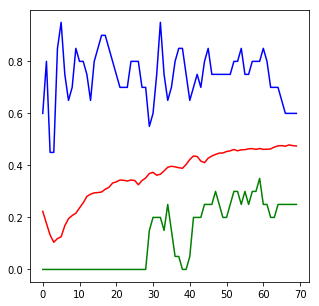

In [28]:
plt.rcParams['figure.figsize'] = [5, 5]
best_hparams_tuple = tuner.hparamsDictToTuple(hparams[best_hparams_index], tuner.tuner_hparams)
cur_res = tuner.results_list[t][best_hparams_tuple]
x = np.arange(0, cur_res[0]['total_updates'] + cur_res[1]['total_updates'], cur_res[0]['updates_per_epoch'])
cur_best_avg = cur_res[1]['best_avg']
cur_best_epoch = cur_res[1]['best_epoch']
updates_per_epoch = cur_res[1]['updates_per_epoch']
# print("dropout: %f, fisher_multiplier: %e, lr: %e" % (k[0], k[1], k[2]))
print("cur_best_avg: %e, num_updates: %d" % (cur_best_avg, cur_best_epoch))
print("best val_acc: %s" % (str(np.array(cur_res[1]['val_acc'])[:, (cur_best_epoch - 1) // tuner.eval_frequency])))
# plt.plot(cur_res['loss_with_penalty'], color='g')
# plt.plot(np.concatenate((cur_res['loss'][0][-1], cur_res['loss'][1][-1]), axis=0), color='b')
# plt.plot(np.concatenate((cur_res[0]['val_loss'][-1], cur_res[1]['val_loss'][-1]), axis=0), color='b')
# plt.show()
# plt.ylim(ymin=0.9)
plt.plot(np.concatenate((cur_res[0]['val_acc'][-1], cur_res[1]['val_acc'][-1]), axis=0), color='b')
plt.plot(np.concatenate((cur_res[0]['val_acc'][1], cur_res[1]['val_acc'][1]), axis=0), color='g')
plt.plot(np.concatenate((cur_res[0]['val_acc'][0], cur_res[1]['val_acc'][0]), axis=0), color='r')
# plt.plot(cur_res['val_acc'][1], color='g')

plt.show()

In [23]:
for hparam in hparams:
    hparam_tuple = tuner.hparamsDictToTuple(hparam, tuner.tuner_hparams)
    print(hparam['epsilon'], np.array(tuner.results_list[t][hparam_tuple][1]['val_acc'])[:, -1])

1.0 [0.50555554 0.40000001 0.44999999]


In [ ]:
# test accuracy
TEST_BATCH_SIZE = 128
test_accuracies = []
for hparam in hparams:
    accuracy = tuner.test(t, BATCH_SIZE, restore_model=True, hparams=hparam)
    test_accuracies.append(accuracy)
    print(hparam['epsilon'], accuracy)

In [ ]:
# Weights given to each class
num_class = 100
for i in range(num_class):
    print(i, np.sum(tuner.appended_task_list[-1].train.weights[(np.argmax(tuner.appended_task_list[-1].train.labels, axis=1) == i)]))

In [ ]:
old_weights = tuner.appended_task_list[1].train.weights[np.argmax(tuner.appended_task_list[1].train.labels, axis=1) != 99]
plt.rcParams['figure.figsize'] = [10, 10]
# plt.hist(old_weights)
# seaborn.distplot(old_weights)
print(old_weights.shape)
print(np.sum(old_weights < 1e-5))
print(np.sum((old_weights >= 1e-5) * (old_weights < 1e-2)))
# for i in range(1000):
#     print(w[i])

In [ ]:
tuner.saveResultsList()
tuner.saveBestHparams()

In [ ]:
TEST_BATCH_SIZE = 128
test_accuracies = []
for i in range(t + 1):
    accuracy = tuner.test(i, TEST_BATCH_SIZE, restore_model=True)
    test_accuracies.append(np.mean(accuracy))

In [ ]:
plt.plot(test_accuracies)
plt.ylim(ymin=0, ymax=1)
plt.show()

In [ ]:
%store -r DB1_test_accuracies
plt.plot(test_accuracies, color='g')
plt.plot(DB1_test_accuracies, color='b')
plt.ylim(ymin=0, ymax=1)
plt.show()

In [ ]:
plt.hist(tuner.appended_task_list[-1].train.weights[0 : tuner.appended_task_list[-2].train.weights.shape[0]], bins='auto')

In [ ]:
if use_tpu:
    sess.run(tpu.shutdown_system())

sess.close()

In [ ]:
import shelve
filename='code_state.bak'
my_shelf = shelve.open(filename,'n') # 'n' for new

for key in dir():
    try:
        my_shelf[key] = globals()[key]
    except TypeError:
        #
        # __builtins__, my_shelf, and imported modules can not be shelved.
        #
        print('ERROR shelving: {0}'.format(key))
my_shelf.close()